1. 이미지 분류 모델을 만들고, 전체 코드와 분류 결과를 주피터 노트북 파일로 깃헙에 제출.
    - 이미지 데이터를 적절히 전처리 후 데이터 파이프라인 설계
    - 모델은 VGG-16(19), ResNet-34(50), GoogLeNet 등 케창딥 교재에 소개된 CNN 모델 중 하나를 선택
    - 텐서플로우 라이브러리에서 모델을 불러오지 않고 직접 모델 학습 코딩
    - Data augmentation 등 케창딥에서 배운 모든 방법을 사용해 최고 기록을 달성
2. (선택) 이미지 분류 학습 결과를 텐서보드로 시각화
    - tensorboard.dev를 사용해 텐서보드 결과를 공유할 수 있는 url 주소 링크를 자신의 깃헙 Main_Quest_2 폴더 내의 Readme.md 파일로 게시
3. (선택) 가장 성능이 좋은 모델에 CAM을 적용해, 분류 결과에 대한 근거를 시각화하고 분석
    - 케창딥의 Class Activation Map 코드를 참고해 페렴 이미지 분류기에 테스트 이미지를 넣고 추론한 결과에 CAM heatmap을 뽑아 주피터 노트북 파일에 포함해 제출

In [45]:
from pathlib import Path
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, SeparableConv2D, BatchNormalization, AveragePooling2D, ZeroPadding2D, Activation, Input, Add, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
data_path = Path('C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/Main_Quest_2/chest_xray')

train_data = image_dataset_from_directory(data_path / 'train', image_size=(150, 150), batch_size=32)
test_data = image_dataset_from_directory(data_path / 'test', image_size=(150, 150), batch_size=32)
val_data = image_dataset_from_directory(data_path / 'val', image_size=(150, 150), batch_size=32)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [4]:
# 데이터와 레이블 크기 확인
for data_batch, labels_batch in train_data:
    print('Size of data batch:', data_batch.shape)
    print('Size of label batch:', labels_batch.shape)
    break

Size of data batch: (32, 150, 150, 3)
Size of label batch: (32,)


In [5]:
# 데이터 증강
train_data_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_data_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_data_aug.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_data_aug.flow_from_directory(
    os.path.join(data_path, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


VGG-16, ResNet-34, GoogLeNet 세 가지 모델을 만든 후 각 모델의 성능을 비교해보자.

In [6]:
# VGG0-16 구현
def VGG16(input_shape=(150, 150, 3), classes=2):
    input = Input(input_shape)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    output = Dense(classes, activation='softmax', name='predictions')(x)

    model = Model(inputs=input, outputs=output, name='VGG-16')
    return model

model_vgg = VGG16()
model_vgg.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()

Model: "VGG-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0    

In [7]:
# ResNet-34 구현을 위한 잔차 연결
def Residual_Block(x, filters, pooling=False):
    residual = x
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    if pooling:
        x = MaxPooling2D(2, padding='same')(x)
        residual = Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = Conv2D(filters, 1)(residual)
    x = Add()([x, residual])

    return x

# ResNet-34 구현
def ResNet34(input_shape=(150, 150, 3), classes=2):
    img_input = Input(shape=input_shape)

    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', name='conv1')(x)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = Residual_Block(x, filters=64)
    x = Residual_Block(x, filters=64)

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    x = Flatten()(x)
    x = Dense(classes, activation='softmax', name='fc' + str(classes))(x)

    model = Model(inputs=img_input, outputs=x, name='ResNet-34')

    return model

model_resnet = ResNet34()
model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "ResNet-34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1[0][0]']          

In [26]:
# GoogLeNet 구현을 위한 Inception 모듈 설계
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    if name is not None:
        output = keras.layers.Layer(name=name)(output)
    return output

# GoogLeNet 구현
def GoogLeNet(input_shape=(150, 150, 3), classes=2):
    input = Input(input_shape)
    
    x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu')(input)
    x = MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)

    x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
    x = MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)

    x = inception_module(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32)
    x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64, name='final_conv')
    
    x = AveragePooling2D((7, 7), strides=(1, 1))(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    
    output = Dense(classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=output, name='GoogLeNet')
    return model

model_google = GoogLeNet()
model_google.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_google.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_84 (Conv2D)             (None, 75, 75, 64)   9472        ['input_9[0][0]']                
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 38, 38, 64)  0           ['conv2d_84[0][0]']              
 )                                                                                                
                                                                                          

In [9]:
# 각 모델에 대한 텐서보드 콜백 생성
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

vgg16_tensorboard_callback = TensorBoard(log_dir='./logs/vgg16', histogram_freq=1)
resnet34_tensorboard_callback = TensorBoard(log_dir='./logs/resnet34', histogram_freq=1)
googlenet_tensorboard_callback = TensorBoard(log_dir='./logs/googlenet', histogram_freq=1)

In [10]:
# 각 모델을 학습
model_vgg.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=50,
    validation_data=val_generator,
    validation_steps=50,
    callbacks=[early_stopping, model_checkpoint, vgg16_tensorboard_callback]
)

model_resnet.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=50,
    validation_data=val_generator,
    validation_steps=50,
    callbacks=[early_stopping, model_checkpoint, resnet34_tensorboard_callback]
)

model_google.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=50,
    validation_data=val_generator,
    validation_steps=50,
    callbacks=[early_stopping, model_checkpoint, googlenet_tensorboard_callback]
)

Epoch 1/50
25/25 [==============================] - 31s 857ms/step - loss: 0.8519 - accuracy: 0.7500 - val_loss: 0.8239 - val_accuracy: 0.5000
Epoch 2/50
25/25 [==============================] - 12s 483ms/step - loss: 0.5633 - accuracy: 0.7513
Epoch 3/50
25/25 [==============================] - 12s 465ms/step - loss: 0.5817 - accuracy: 0.7362
Epoch 4/50
25/25 [==============================] - 12s 465ms/step - loss: 0.5493 - accuracy: 0.7638
Epoch 5/50
25/25 [==============================] - 12s 459ms/step - loss: 0.5836 - accuracy: 0.7312
Epoch 6/50
25/25 [==============================] - 11s 450ms/step - loss: 0.5603 - accuracy: 0.7538
Epoch 7/50
25/25 [==============================] - 12s 462ms/step - loss: 0.5729 - accuracy: 0.7425
Epoch 8/50
25/25 [==============================] - 11s 448ms/step - loss: 0.5802 - accuracy: 0.7350
Epoch 9/50
25/25 [==============================] - 12s 467ms/step - loss: 0.5601 - accuracy: 0.7538
Epoch 10/50
25/25 [==============================

In [12]:
# 각 모델들을 평가
vgg_loss, vgg_accuracy = model_vgg.evaluate(val_generator)
print(f"VGG16 Validation Loss: {vgg_loss}")
print(f"VGG16 Validation Accuracy: {vgg_accuracy}")

# ResNet34 모델 평가
resnet_loss, resnet_accuracy = model_resnet.evaluate(val_generator)
print(f"ResNet34 Validation Loss: {resnet_loss}")
print(f"ResNet34 Validation Accuracy: {resnet_accuracy}")

# GoogLeNet 모델 평가
google_loss, google_accuracy = model_google.evaluate(val_generator)
print(f"GoogLeNet Validation Loss: {google_loss}")
print(f"GoogLeNet Validation Accuracy: {google_accuracy}")


1/1 [==============================] - 0s 340ms/step - loss: 0.8369 - accuracy: 0.5000
VGG16 Validation Loss: 0.8368690013885498
VGG16 Validation Accuracy: 0.5
1/1 [==============================] - 0s 118ms/step - loss: 1.4888 - accuracy: 0.5000
ResNet34 Validation Loss: 1.4887579679489136
ResNet34 Validation Accuracy: 0.5
1/1 [==============================] - 0s 118ms/step - loss: 0.3628 - accuracy: 0.8125
GoogLeNet Validation Loss: 0.3627644181251526
GoogLeNet Validation Accuracy: 0.8125


가장 좋은 성능을 냈던 GoogLeNet에 CAM을 적용하여 분류 결과에 대해서 분석하고 시각화해보자.

In [31]:
img_path = 'C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/Main_Quest_2/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg'

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(150, 150))

In [37]:
def decode_predictions(preds, top=2):
    CLASS_INDEX = {0: 'NORMAL', 1: 'PNEUMONIA'}
    results = []

    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [(CLASS_INDEX[i], pred[i]) for i in top_indices]
        results.append(result)

    return results

preds = model_google.predict(img_array)
print('Predicted:', decode_predictions(preds, top=2)[0])

1/1 [==============================] - 0s 14ms/step
Predicted: [('PNEUMONIA', 0.58928555), ('NORMAL', 0.41071448)]


In [38]:
last_conv_name = 'final_conv'
classifier_names = [
    'avg_pool',
    'predictions'
]

last_conv_layer = model_google.get_layer(last_conv_name)
last_conv_model = keras.Model(model_google.input, last_conv_layer.output)

In [39]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_names:
    x = model_google.get_layer(last_conv_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [42]:
with tf.GradientTape() as tape:
    last_conv_output = last_conv_model(img_array)
    tape.watch(last_conv_output)
    preds = classifier_model(last_conv_output)
    top_class_channel = tf.reduce_max(preds, axis=1)

grads = tape.gradient(top_class_channel, last_conv_output)

In [43]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_output = last_conv_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_output, axis=1)

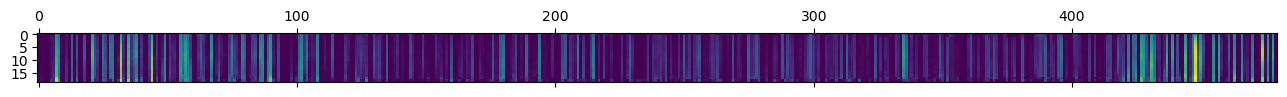

In [44]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [47]:
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap('jet')
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = 'pneumonia_cam.jpg'
superimposed_img.save(save_path)

C:\Users\ZAKAR\AppData\Local\Temp\ipykernel_8744\2986307205.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


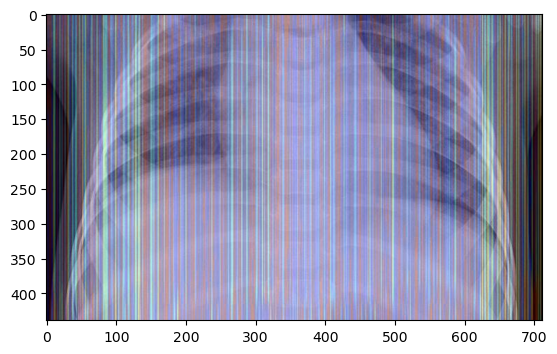

In [50]:
cam_img = cv2.imread('C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/Main_Quest_2/pneumonia_cam.jpg')
plt.imshow(cam_img)